In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# Load CIFAR-10 Dataset

### **CIFAR-10 Dataset**: It consists of 60,000 32x32 color images in 10 classes. Here, only the training set (X_train) is used, and the images are normalized to values between 0 and 1 to improve training stability.

In [5]:
# Load CIFAR-10 dataset
(X_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]

170498071/170498071 [==============================] - 41s 0us/step


# Build Generator

### The **generator** creates images that resemble real data from a random noise vector (input_dim=100), also called a latent space. It uses Convolutional Transpose layers (also known as deconvolution or upsampling layers) to gradually increase the spatial dimensions and convert the input noise into a 32x32 RGB image.

### ***Dense(256 * 8 * 8)***: The noise vector is transformed into a 256-channel feature map of shape 8x8.

### ***Reshape((8, 8, 256))***: Reshapes the dense output into a 3D feature map.

### ***Conv2DTranspose***: These layers upsample the feature maps to 16x16 and 32x32. Strides of 2 are used to double the spatial dimensions.

### ***Conv2D(3)***: The output is a 32x32 image with 3 channels (RGB). Tanh activation scales the pixel values to the range [-1, 1] to match the normalized CIFAR-10 images.

In [7]:
# Generator model (DCGAN)
def build_generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(8 * 8 * 256, input_dim=100))  # Start from a low-dimensional space
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))  # Now this will output (16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))  # Now this will output (32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', activation='tanh'))  # Output will be (32, 32, 3)

    return model

generator = build_generator()
generator.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 batch_normalization (Batch  (None, 8, 8, 256)         1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       524416    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)      

# Building the Discriminator

### The **discriminator** tries to differientiate between real and generated (fake) images. It outputs a probability between 0 (fake) and 1 (real) using a sigmoid activation.

### ***Conv2D(64)***: Applies convolution with a kernel size of 5 and a stride of 2 to downsample the 32x32 image to 16x16.

### ***LeakyReLU(0.2)***: An activation function similar to ReLU, but with a small slope for negative values (alpha = 0.2). This prevents neurons from dying during training (which can happen with ReLU).

### ***Conv2D(128)***: Further downsampling the feature map from 16x16 to 8x8.

### ***Flatten()***: Converts the 3D feature maps into a 1D vector for the dense output layer.

### ***Dense(1, sigmoid)***: Produces a single output between 0 and 1 representing whether the input image is real or fake.

In [9]:
# Discriminator model (DCGAN)
def build_discriminator():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model



# Call the discriminator
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524544    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 512)        

# Compile the Models

### The ***discriminator is compiled with the binary cross-entropy loss function since it performs binary classification*** (real vs. fake). The Adam optimizer is used to optimize the model.

In [11]:
# Build and compile models
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input = layers.Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')

# Train the function

### ***Noise Generation***: A batch of random noise vectors is generated and passed through the generator to produce fake images.

### ***Discriminator Training***: The discriminator is trained on both real and fake images. The real images are labeled as 0.9 (soft label, slightly less than 1 to prevent overconfidence), and the fake images are labeled as 0. Both are concatenated into one batch.

### ***Generator Training***: The generator tries to fool the discriminator, so it’s trained with the goal that the discriminator labels the generated images as real (1). During this phase, the discriminator's weights are frozen (discriminator.trainable = False).

### ***Loss Calculation***: After each epoch, the losses of both the discriminator (d_loss) and generator (g_loss) are printed.

In [13]:
# Training function
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, real)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch)

# Image Generation Function

### This function generates images from random noise using the generator and plots them in a grid using Matplotlib. The images are rescaled from the [-1, 1] range (from the tanh activation) back to [0, 1] for viewing.

2/2 [==============================] - 1s 46ms/step


0 [D loss: 0.6931432783603668, acc.: 42.1875%] [G loss: 0.506666898727417]
1/1 [==============================] - 0s 355ms/step


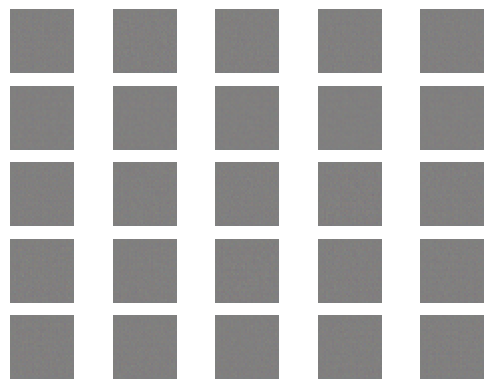

2/2 [==============================] - 0s 36ms/step


In [15]:
# Function to save generated images
def save_images(epoch):
    noise = np.random.normal(0, 1, (25, 100))
    gen_images = generator.predict(noise)
    gen_images = 0.5 * gen_images + 0.5  # Rescale from [-1, 1] to [0, 1]

    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_images[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the DCGAN
train(epochs=1000, batch_size=64, save_interval=1000)

# Question 01

## **Modify the DCGAN to generate images for a specific class (e.g., cars, airplanes). Generate 10 examples of each class and analyze the quality and variety of the generated images.**

---

# Question 02

## **Apply data augmentation (random cropping, flipping, etc.) to the real CIFAR-10 images during discriminator training. Evaluate if augmentation improves the discriminator's performance and results in better-generated images.**

---

# Question 03

## **Implement the Inception Score to evaluate the quality of generated images. Train the DCGAN and compute the IS at various points (e.g., 2000, 5000, 10000 epochs). Compare the IS values with the visual quality of generated images.**

---

# Question 04

## **Add more layers to the generator and discriminator to create deeper models. Train the deeper DCGAN and observe if this complexity improves the quality of generated images.**





In [18]:
# 1

In [30]:
# Load CIFAR-10 dataset with labels
(X_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
y_train = y_train.reshape(-1, 1)
num_classes = 10


In [31]:
def build_generator():
    noise_input = layers.Input(shape=(100,))
    label_input = layers.Input(shape=(1,), dtype='int32')

    # Embedding layer for labels
    label_embedding = layers.Embedding(num_classes, 100)(label_input)
    label_embedding = layers.Flatten()(label_embedding)

    # Concatenate noise and label embeddings
    input_combined = layers.multiply([noise_input, label_embedding])

    model = tf.keras.Sequential()
    model.add(layers.Dense(8 * 8 * 256, input_dim=100))
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', activation='tanh'))

    gen_output = model(input_combined)
    return tf.keras.Model([noise_input, label_input], gen_output)


In [32]:
def build_discriminator():
    image_input = layers.Input(shape=(32, 32, 3))
    label_input = layers.Input(shape=(1,), dtype='int32')

    # Embedding layer for labels
    label_embedding = layers.Embedding(num_classes, 32 * 32 * 3)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((32, 32, 3))(label_embedding)

    # Concatenate image and label embedding
    input_combined = layers.concatenate([image_input, label_embedding])

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(32, 32, 6)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    disc_output = model(input_combined)
    return tf.keras.Model([image_input, label_input], disc_output)


2/2 [==============================] - 1s 48ms/step
0 [D loss: 0.6958268582820892, acc.: 34.375%] [G loss: 0.4673757553100586]
1/1 [==============================] - 0s 318ms/step


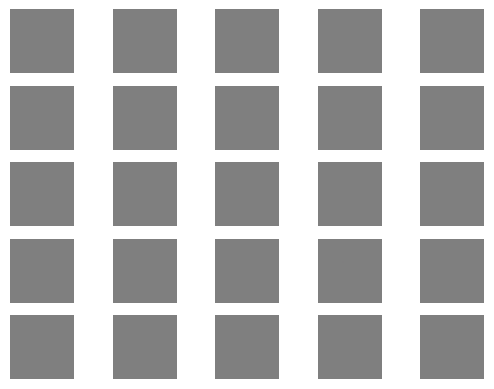

2/2 [==============================] - 0s 40ms/step
1000 [D loss: 0.0023145274026319385, acc.: 100.0%] [G loss: 0.006492597982287407]
1/1 [==============================] - 0s 62ms/step


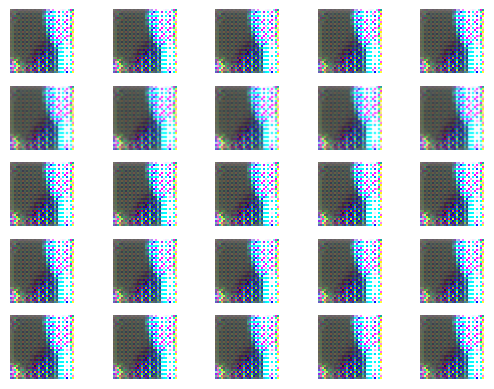

2/2 [==============================] - 0s 31ms/step
2000 [D loss: 0.00019358018131043764, acc.: 100.0%] [G loss: 0.0031898352317512035]
1/1 [==============================] - 0s 41ms/step


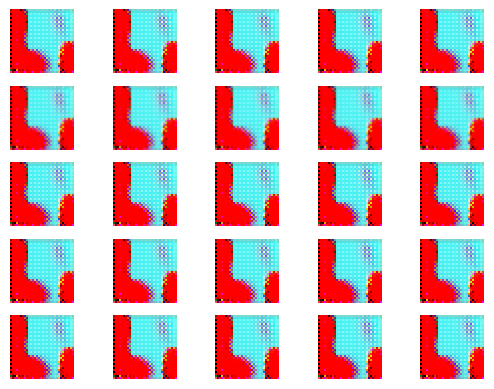

2/2 [==============================] - 0s 42ms/step
3000 [D loss: 6.592926526138854e-05, acc.: 100.0%] [G loss: 0.019578851759433746]
1/1 [==============================] - 0s 49ms/step


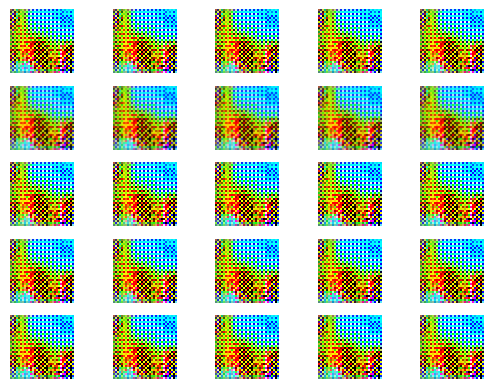

2/2 [==============================] - 0s 40ms/step
4000 [D loss: 0.0003314004645202928, acc.: 100.0%] [G loss: 1.0356221199035645]
1/1 [==============================] - 0s 44ms/step


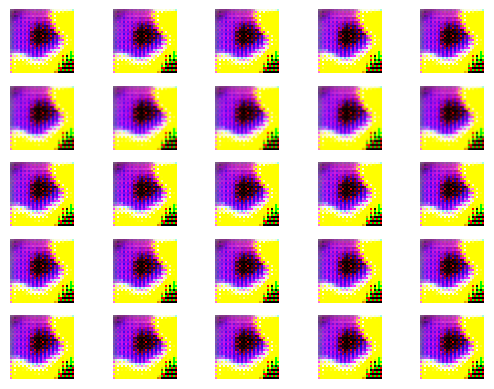

2/2 [==============================] - 0s 37ms/step
5000 [D loss: 0.0006072859553682974, acc.: 100.0%] [G loss: 0.046600230038166046]
1/1 [==============================] - 0s 57ms/step


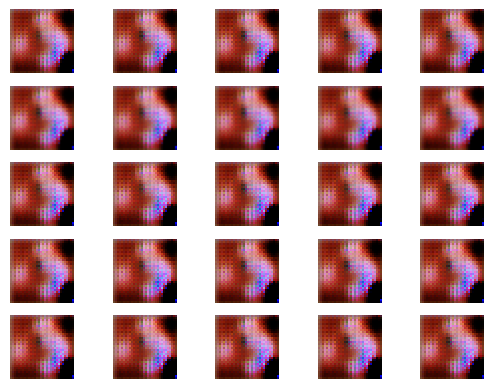

2/2 [==============================] - 0s 38ms/step
6000 [D loss: 0.0014363243255835368, acc.: 100.0%] [G loss: 6.72255802154541]
1/1 [==============================] - 0s 61ms/step


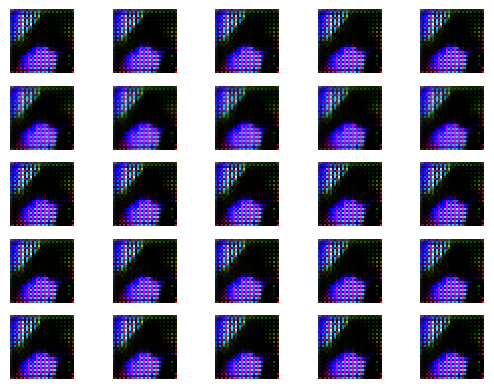

2/2 [==============================] - 0s 35ms/step
7000 [D loss: 0.0012497124662331771, acc.: 100.0%] [G loss: 0.04204411804676056]
1/1 [==============================] - 0s 53ms/step


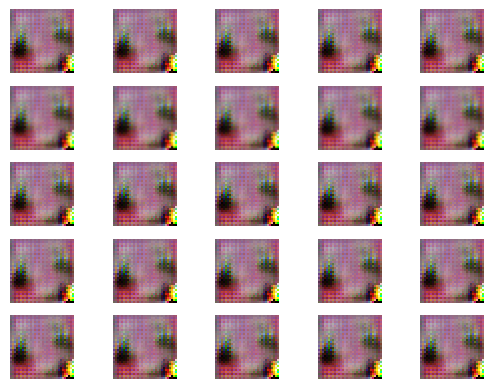

2/2 [==============================] - 0s 41ms/step
8000 [D loss: 0.0006123582500148217, acc.: 100.0%] [G loss: 7.498261451721191]
1/1 [==============================] - 0s 64ms/step


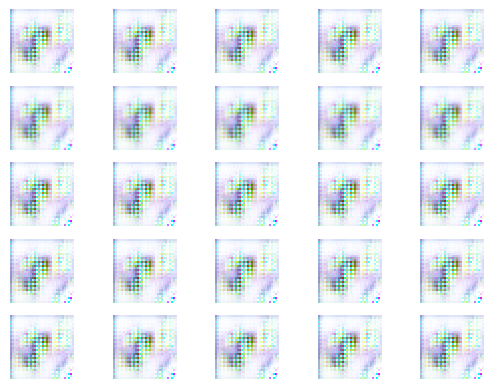

2/2 [==============================] - 0s 54ms/step


KeyboardInterrupt: 

In [33]:
# Compile models
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

noise_input = layers.Input(shape=(100,))
label_input = layers.Input(shape=(1,), dtype='int32')
generated_image = generator([noise_input, label_input])
gan_output = discriminator([generated_image, label_input])

gan = tf.keras.Model([noise_input, label_input], gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')

# Training function for conditional GAN
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        real_labels = y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_labels = np.random.randint(0, num_classes, batch_size)
        fake_images = generator.predict([noise, fake_labels])

        d_loss_real = discriminator.train_on_batch([real_images, real_labels], real)
        d_loss_fake = discriminator.train_on_batch([fake_images, fake_labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_labels = np.random.randint(0, num_classes, batch_size)
        g_loss = gan.train_on_batch([noise, fake_labels], real)

        # Print the progress
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch)

# Save generated images with labels
def save_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.array([num for _ in range(r) for num in range(c)])

    gen_images = generator.predict([noise, sampled_labels])
    gen_images = 0.5 * gen_images + 0.5  # Rescale from [-1, 1] to [0, 1]

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_images[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the conditional GAN
train(epochs=10000, batch_size=64, save_interval=1000)


In [ ]:
#2

In [ ]:
# Augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])


In [ ]:
# Training function for GAN with data augmentation
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Train discriminator on real images (with augmentation)
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        real_labels = y_train[idx]

        # Apply data augmentation to the real images
        real_images_augmented = data_augmentation(real_images)

        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_labels = np.random.randint(0, num_classes, batch_size)
        fake_images = generator.predict([noise, fake_labels])

        # Train discriminator
        d_loss_real = discriminator.train_on_batch([real_images_augmented, real_labels], real)
        d_loss_fake = discriminator.train_on_batch([fake_images, fake_labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_labels = np.random.randint(0, num_classes, batch_size)
        g_loss = gan.train_on_batch([noise, fake_labels], real)

        # Print the progress
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch)


In [23]:
#3

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from scipy.stats import entropy
import numpy as np
import math

# Load the pre-trained InceptionV3 model
inception_model = InceptionV3(include_top=True, weights='imagenet')

# Remove the top layers to output the predictions (logits)
inception_model = Model(inputs=inception_model.input, outputs=inception_model.get_layer('predictions').output)

# Function to resize and preprocess images for Inception model
def preprocess_images(images):
    images_resized = tf.image.resize(images, (299, 299))  # Resize to 299x299
    return preprocess_input(images_resized)  # Preprocess for InceptionV3

# Compute the KL divergence for Inception Score
def calculate_inception_score(images, splits=10):
    images = preprocess_images(images)
    preds = inception_model.predict(images)

    # Split the predictions into smaller groups to compute the inception score
    split_size = images.shape[0] // splits
    scores = []
    for i in range(splits):
        part = preds[i * split_size: (i + 1) * split_size, :]
        p_yx = np.mean(part, axis=0)  # Compute p(y)
        kl_divergence = part * (np.log(part) - np.log(p_yx[np.newaxis, :]))
        kl_divergence = np.sum(kl_divergence, axis=1)
        scores.append(np.exp(np.mean(kl_divergence)))

    return np.mean(scores), np.std(scores)

# Generate a batch of images using the trained generator
def generate_images(generator, num_images, latent_dim=100, labels=None):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    if labels is None:
        labels = np.random.randint(0, num_classes, num_images)
    return generator.predict([noise, labels])

# Function to evaluate the Inception Score at different epochs
def evaluate_inception_score_at_epochs(generator, num_images=1000, epochs=[2000, 5000, 10000]):
    for epoch in epochs:
        print(f"Evaluating Inception Score at {epoch} epochs...")
        generated_images = generate_images(generator, num_images)
        inception_score, std = calculate_inception_score(generated_images)
        print(f"Inception Score at {epoch} epochs: {inception_score} ± {std}")
        save_images(generated_images, epoch)

# Function to save generated images for visual comparison
def save_images(images, epoch):
    images = 0.5 * images + 0.5  # Rescale to [0, 1]
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(images[cnt])
            axs[i, j].axis('off')
            cnt += 1
    plt.suptitle(f'Generated Images at Epoch {epoch}')
    plt.show()

# Call this function during DCGAN training
evaluate_inception_score_at_epochs(generator, epochs=[2000, 5000, 10000])


In [24]:
#4

In [ ]:
def build_deep_generator():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(8 * 8 * 512, input_dim=100))  # Increased from 256 to 512
    model.add(layers.Reshape((8, 8, 512)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'))  # (16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))  # (32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))  # (64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', activation='tanh'))  # (64, 64, 3)
    
    return model


In [ ]:
def build_deep_discriminator():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))  # (16, 16, 64)
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))  # (8, 8, 128)
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))  # (4, 4, 256)
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))  # (2, 2, 512)
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model


In [ ]:
# Build and compile deeper models
deep_generator = build_deep_generator()
deep_discriminator = build_deep_discriminator()

deep_discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
deep_discriminator.trainable = False

gan_input = layers.Input(shape=(100,))
generated_image = deep_generator(gan_input)
gan_output = deep_discriminator(generated_image)

deep_gan = tf.keras.Model(gan_input, gan_output)
deep_gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')

# Train the deeper DCGAN
train(epochs=10000, batch_size=64, save_interval=1000)
